# LINMA2222 - Stochastic Optimal Control & Reinforcement Learning
## Portfolio optimal strategy
---

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Constants

In [2]:
THETA = 0.5
W_A = 0.1
W_U = 0.2
SIGMA_A = 0.018
SIGMA_P = 0.02
BETA_U = -0.048
GAMMA_U = 0.06

### Plot functions

In [3]:
def generate_trajectories(policy, x0=(0, 0, 0), T=1000, N=1, xi_a=None, xi_p=None):
    """Generate the state variables x_t and actions u_t for t=0,...,T
       using the given policy.

    Args:
        policy: a function that takes in the current state x_t and returns an action u_t
        x0 (ndarray): initial state. Defaults to 0.
        T (int): number of time steps. Defaults to 1000.
    """
    x = np.zeros((T+1, 3, N))  # State variables: q_t, za_t, zu_t
    u = np.zeros((T, N))       # Actions
    x[0] = np.array(x0).reshape(3, 1)
    if xi_a is None:  xi_a = np.random.normal(0, 1, size=(T, N))
    if xi_p is None:  xi_p = np.random.normal(0, 1, size=(T, N))

    for t in range(T):
        u[t] = policy(x[t])
        x[t+1, 0] = x[t, 0] + u[t] # q_t
        x[t+1, 1] = (1 - W_A) * x[t, 1] + W_A * SIGMA_A * xi_a[t]  # za_t
        x[t+1, 2] = (1 - W_U) * x[t, 2] + W_U * BETA_U * u[t]  # zu_t

    return x, u, xi_p


def g(q, za, zu , u, xi_p=None):
    """Compute the gross stage reward at each time given state x and action u."""
    # q, za, zu = x[:, 0], x[:, 1], x[:, 2]
    if xi_p is None:
        xi_p = np.random.normal(0, 1, size=q.shape[0])

    # Formula found by replacing p_t+1 and p_t by their expressions in the given model (see Question 2.3)
    return q * (za + zu + (GAMMA_U * u) + (SIGMA_P * xi_p)) + THETA * u * (za + zu + (SIGMA_P * xi_p))


def c(g):
    """Compute the net stage reward given gross stage reward g_t for each time t"""
    return np.maximum(g - (np.pow(g, 2) / 2), 1 - np.exp(-g))

def reward(x, u, xi_p, t):
    """Compute all the rewards over the trajectory given states x and actions u from time 0 to t."""
    """returns an array of shape (t,)"""
    g_t = g(x[:t, 0], x[:t, 1], x[:t, 2], u[:t], xi_p=xi_p[:t])
    c_t = c(g_t)
    return c_t

def average_reward(x, u, xi_p, t):
    return np.mean(reward(x, u, xi_p, t))


def generate_trajectories_and_avg_reward(policy, x0=(0, 0, 0), T=1000, N=1):
    """compute efficienctly the average reward over T time steps

    Args:
        policy: a function that takes in the current state x_t and returns an action u_t
        x0 (ndarray): initial state. Defaults to 0.
        T (int): number of time steps. Defaults to 1000.
    """
    u = 0
    x = np.zeros(3)

    total_reward = 0
    for t in range(T):
        u = policy(x)
        x[0] = x[0] + u # q_t
        x[1] = (1 - W_A) * x[1] + W_A * SIGMA_A * np.random.normal(0, 1)  # za_t
        x[2] = (1 - W_U) * x[2] + W_U * BETA_U * u  # zu_t
        g_t = g(x[0], x[1], x[2], u, xi_p=np.random.normal(0, 1))
        c_t = c(g_t)
        total_reward += c_t
    return total_reward / T


def plot_trajectories(x, u, xi_p, filename=None, mean=False, variance=False):
    """Plot the trajectories of the state variables and actions over time in a 2x2 grid
       and add an additional plot for the average reward as a function of time."""
    
    print(f"Plotting {filename} : reward = {average_reward(x, u, xi_p, x.shape[0]-1)}")
    
    T = x.shape[0] - 1
    time = np.arange(T+1)

    fig, axs = plt.subplots(2, 2, figsize=(18, 10))

    axs[0, 0].plot(time, x[:, 0], label=r'$q_t$', color='blue')
    if mean:
        axs[0, 0].hlines(np.mean(x[:, 0]), 0, T, colors='darkblue', linestyles='dashed', label='Mean')
    if variance:
        axs[0, 0].fill_between(time, np.mean(x[:, 0]) - np.std(x[:, 0]), np.mean(x[:, 0]) + np.std(x[:, 0]), color='cyan', alpha=0.3, label='Variance')
    axs[0, 0].set_title(r'$q_t$')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel(r'$q_t$')
    axs[0, 0].grid()
    axs[0, 0].legend()

    axs[0, 1].plot(time, x[:, 1], label=r'$z^{a}_{t}$', color='orange')
    if mean:
        axs[0, 1].hlines(np.mean(x[:, 1]), 0, T, colors='darkorange', linestyles='dashed', label='Mean')
    if variance:
        axs[0, 1].fill_between(time, np.mean(x[:, 1]) - np.std(x[:, 1]), np.mean(x[:, 1]) + np.std(x[:, 1]), color='moccasin', alpha=1, label='Variance')
    axs[0, 1].set_title(r'$z^{a}_{t}$')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel(r'$z^{a}_{t}$')
    axs[0, 1].grid()
    axs[0, 1].legend()

    axs[1, 0].plot(time, x[:, 2], label=r'$z^{u}_{t}$', color='green')
    if mean:
        axs[1, 0].hlines(np.mean(x[:, 2]), 0, T, colors='darkgreen', linestyles='dashed', label='Mean')
    if variance:
        axs[1, 0].fill_between(time, np.mean(x[:, 2]) - np.std(x[:, 2]), np.mean(x[:, 2]) + np.std(x[:, 2]), color='lightgreen', alpha=1, label='Variance')
    axs[1, 0].set_title(r'$z^{u}_{t}$')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel(r'$z^{u}_{t}$')
    axs[1, 0].grid()
    axs[1, 0].legend()

    axs[1, 1].plot(time[:-1], u, label=r'$u_{t}$', color='red')
    if mean:
        axs[1, 1].hlines(np.mean(u), 0, T-1, colors='darkred', linestyles='dashed', label='Mean')
    if variance:
        axs[1, 1].fill_between(time[:-1], np.mean(u) - np.std(u), np.mean(u) + np.std(u), color='lightcoral', alpha=1, label='Variance')
    axs[1, 1].set_title(r'$u_{t}$')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel(r'$u_{t}$')
    axs[1, 1].grid()
    axs[1, 1].legend()

    plt.tight_layout()
    if filename:
        plt.savefig("figures/" + filename + "_states_actions.svg", format='svg')
    plt.show()

    # plot_average_reward(x, u, xi_p, T=T, filename=filename)







def plot_average_reward(x, u, xi_p, T=1000, filename=None):
    # Plot average reward as a function of time
    avg_rewards = [np.mean(reward(x, u, xi_p, t)) for t in range(1, T+1)]
    
    plt.figure(figsize=(9, 5))
    plt.plot(np.arange(1, T+1), avg_rewards, label='Average Reward', color='purple')
    plt.title('Average Reward Over Time')
    plt.xlabel('Time')
    plt.ylabel('Average Reward')
    plt.grid()

    plt.legend()
    if filename:
        plt.savefig("figures/" + filename + "_average_reward.svg", format='svg')
    plt.show()



### Question 3.1

$\pi_{cl}(x_t) = K_{cl} x_t$


Plotting question_3_1_1 : reward = 9.343828796871682e-06


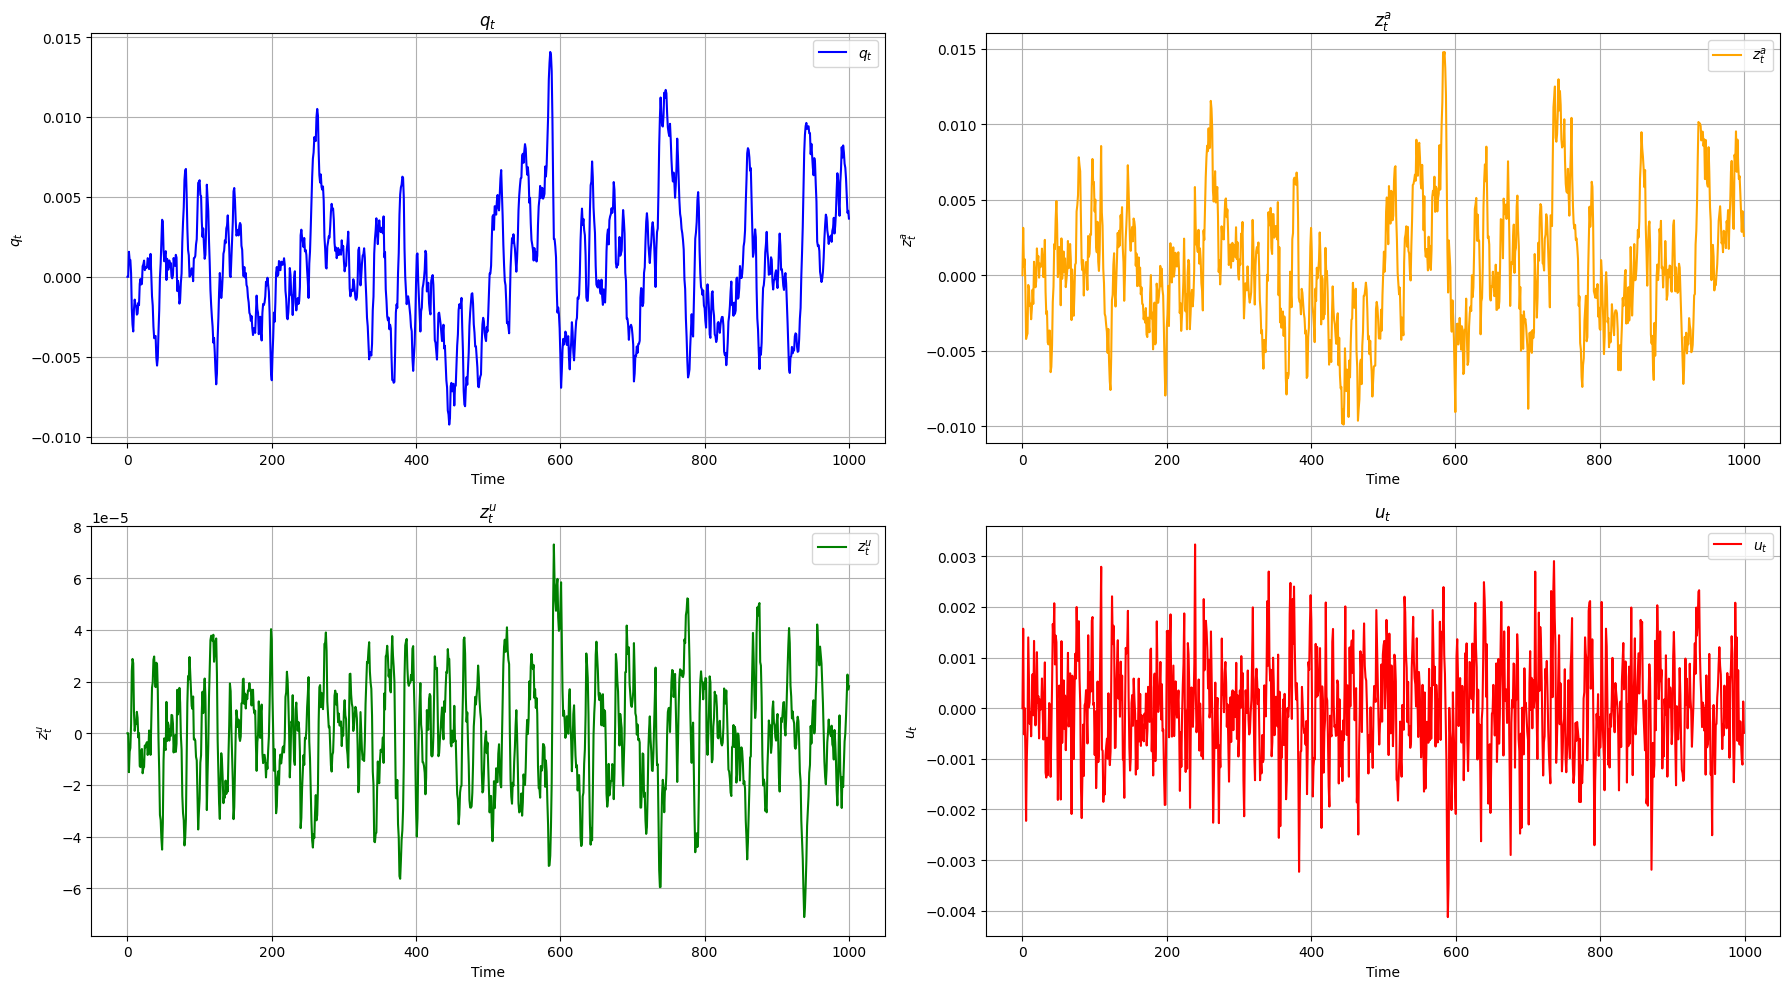

Plotting question_3_1_1 : reward = 5.571410882239721e-06


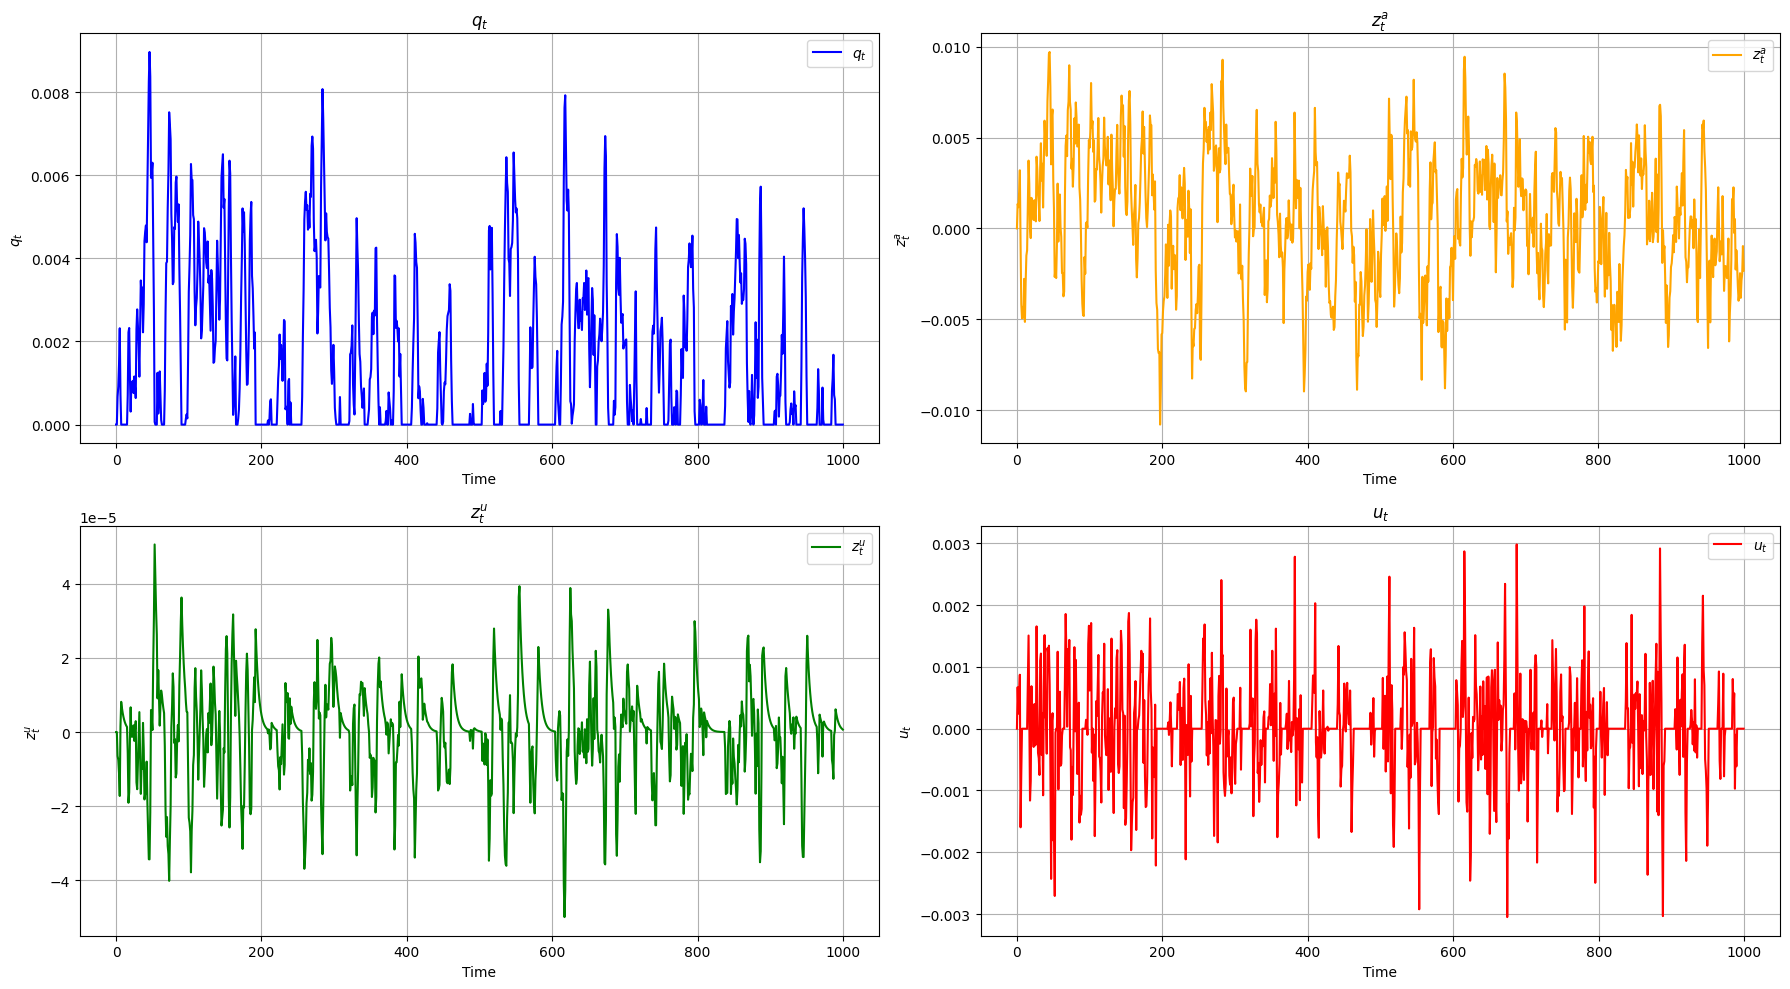

In [4]:
# Question 3.1.1
policy = lambda x: -0.5 * x[0] + 0.5 * x[1] + 0.5 * x[2]
cliped_policy = lambda x: np.clip(policy(x), -x[0], 1-x[0])

x, u, xi_p = generate_trajectories(policy, x0=(0, 0, 0), T=1000)
plot_trajectories(x, u, xi_p, filename="question_3_1_1")

x, u, xi_p = generate_trajectories(cliped_policy, x0=(0, 0, 0), T=1000)
plot_trajectories(x, u, xi_p, filename="question_3_1_1")



Average reward of unclipped policy over 1000 trajectories: 1.4644142520918912e-05 and std: 7.970219298430226e-05


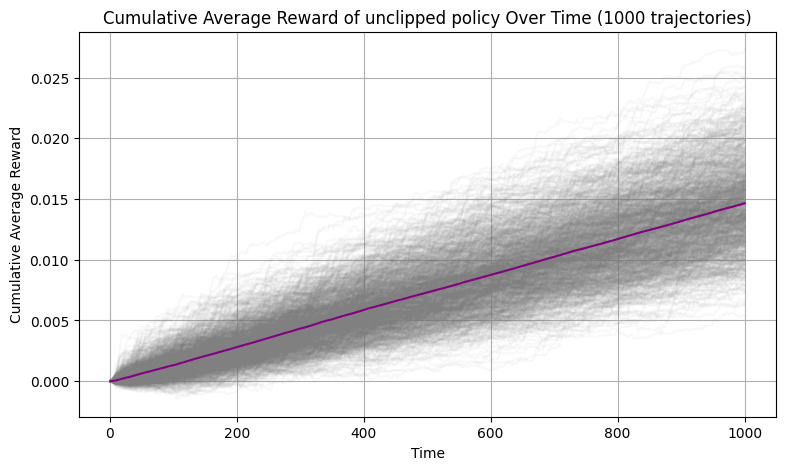

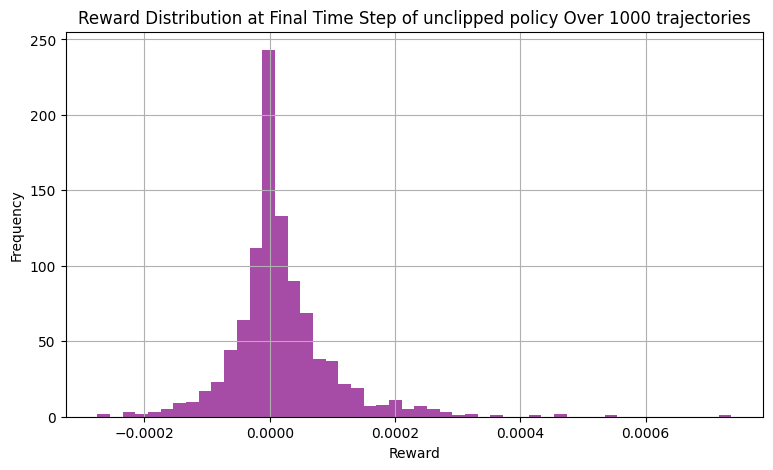

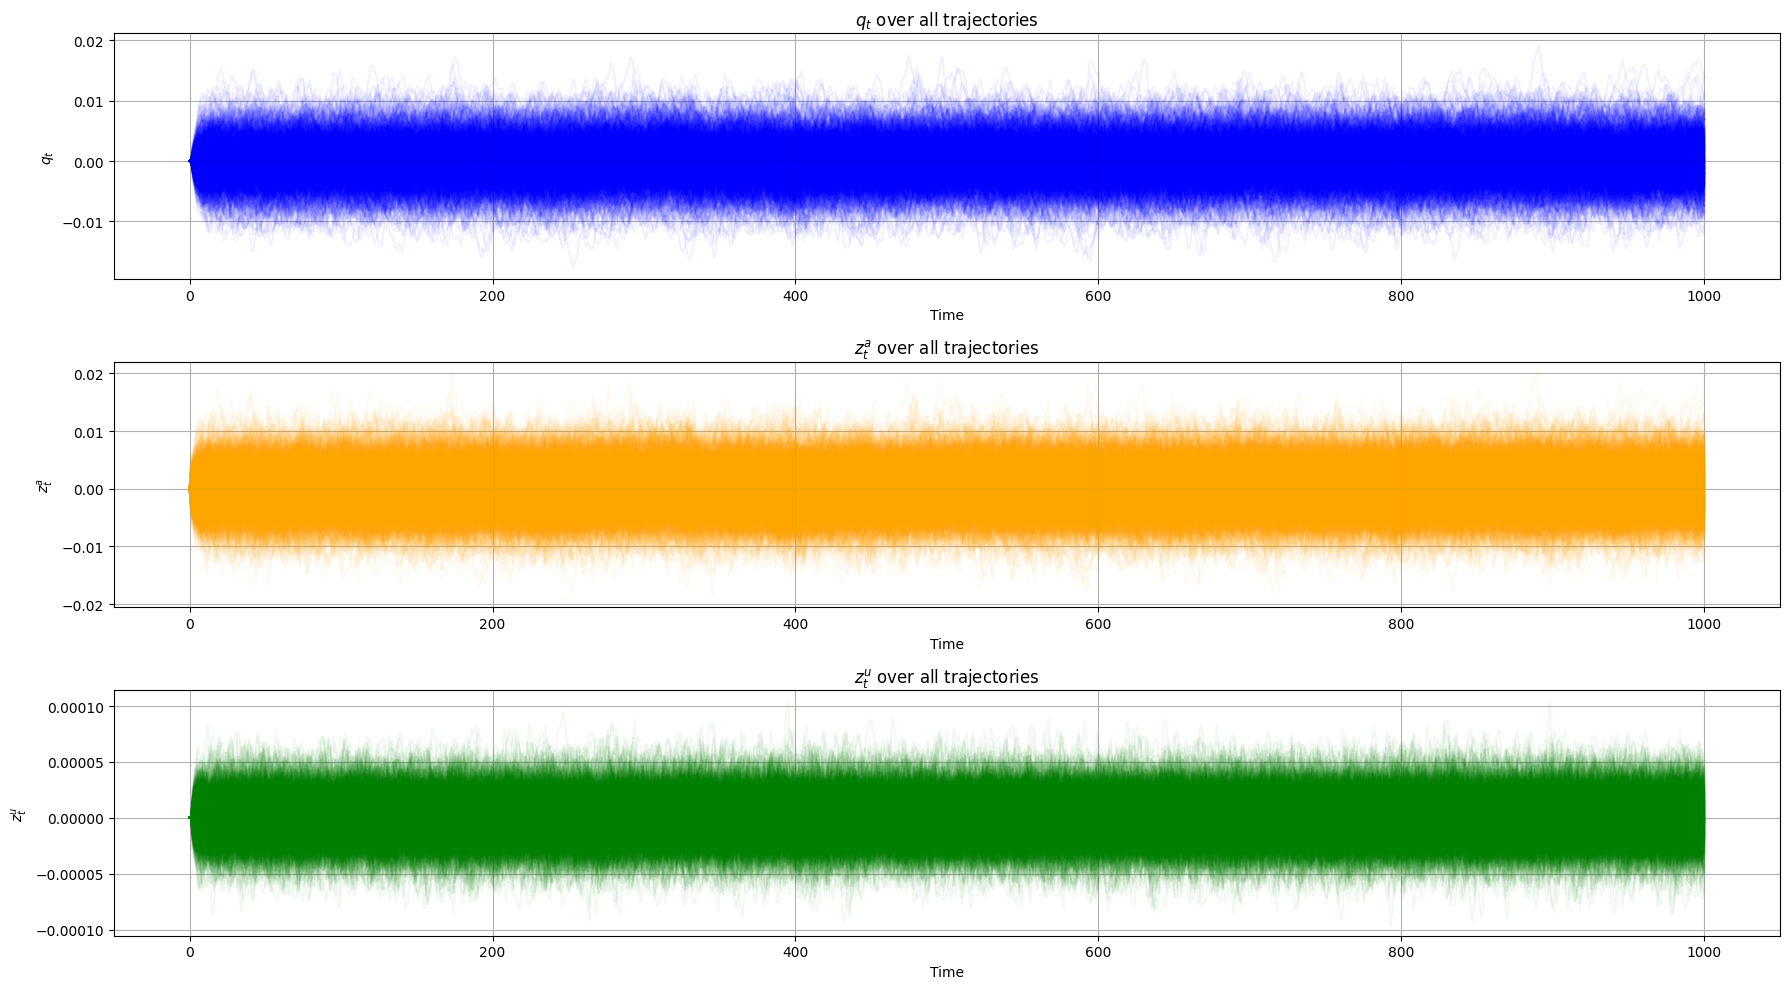

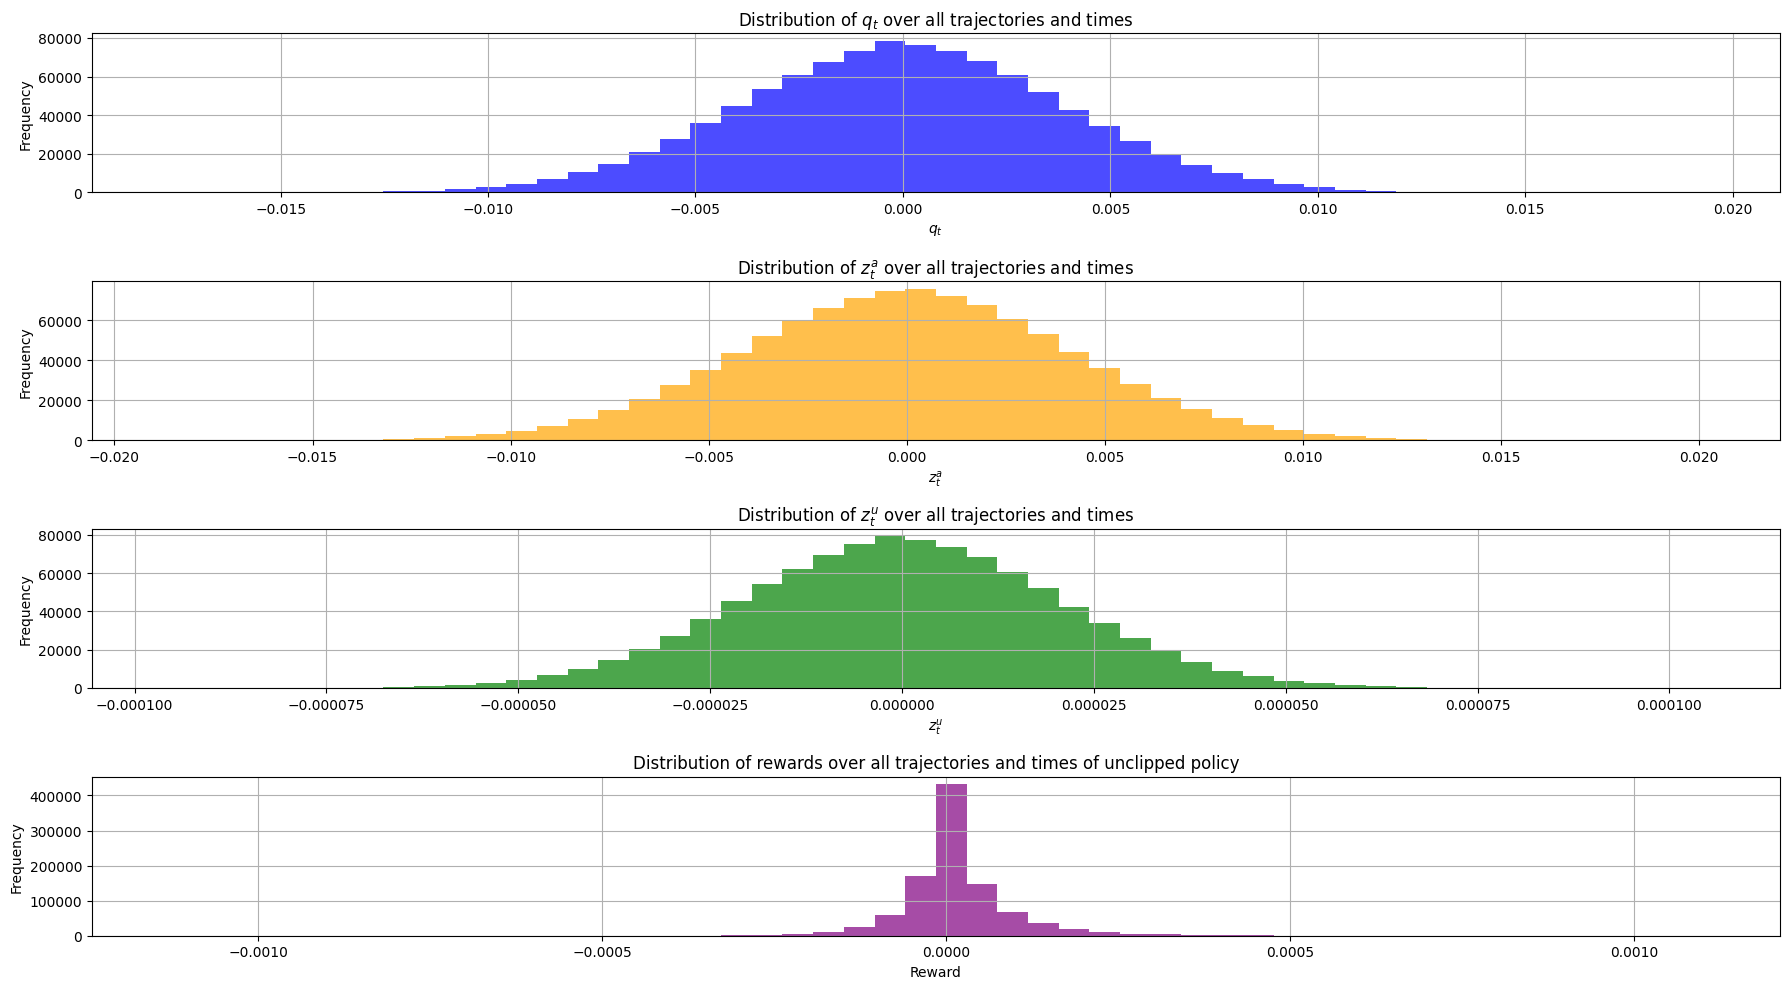

Average reward of clipped policy over 1000 trajectories: 7.47620018000743e-06 and std: 5.73635356841638e-05


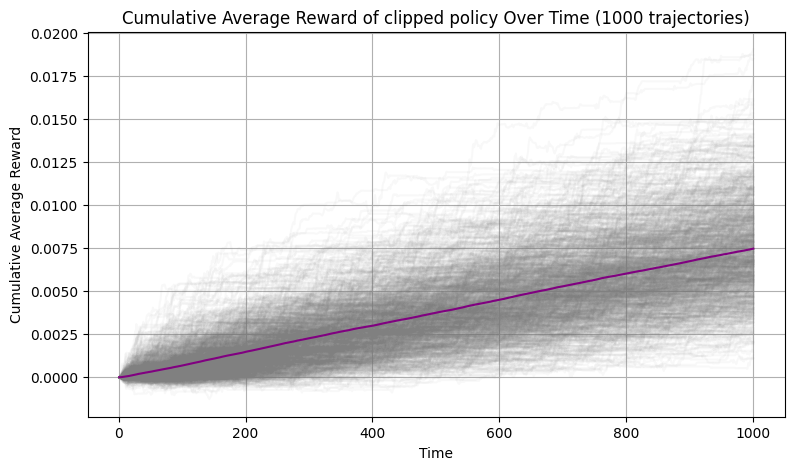

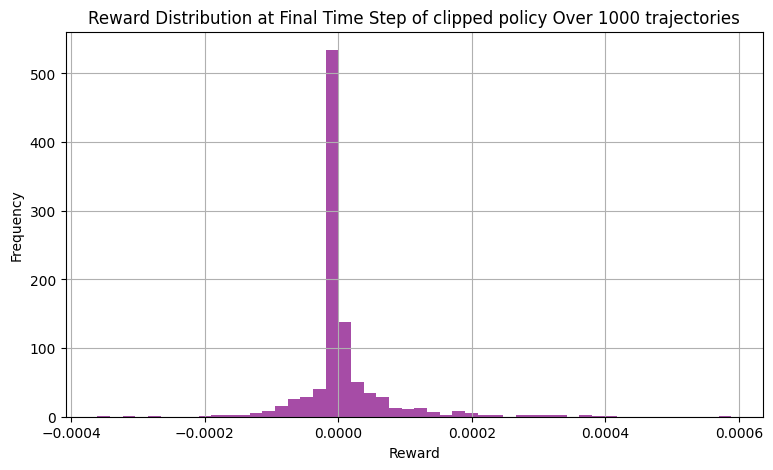

KeyboardInterrupt: 

In [5]:

# Question 3.1.2
N = 1000
def run_trajectories(policy, N=1000, name="policy", show_all=False):
    """Run N trajectories using the given policy and plot the average reward over time."""
    if show_all:
        all_x = np.zeros(( 1001, 3, N))
        all_u = np.zeros((1000, N))
        all_xi_p = np.zeros((1000, N))

    all_rewards = np.zeros((1000, N))

    # for i in range(N):
    #     x, u, xi_p = generate_trajectories(policy, x0=(0, 0, 0), T=1000)
    #     if show_all:
    #         all_x[i] = x
    #         all_u[i] = u
    #         all_xi_p[i] = xi_p
    #     all_rewards[i] = reward(x, u, xi_p, 1000)

    all_x, all_u, all_xi_p = generate_trajectories(policy, x0=(0, 0, 0), T=1000, N=N)
    all_rewards = reward(all_x[:, :, :], all_u[:, :], all_xi_p[:, :], 1000).T

    reward_mean = np.mean(all_rewards, axis=0) # average reward for each time step

    print(f"Average reward of {name} over {N} trajectories: {np.mean(all_rewards)} and std: {np.std(all_rewards)}")

    ### plot the average reward
    # plt.figure(figsize=(9, 5))
    # for i in range(N):
    #     plt.plot(np.arange(1, 1001), all_rewards[i], color='gray', alpha=0.05)
    # plt.plot(np.arange(1, 1001), reward_mean, label='Average Reward',color='purple')
    # plt.title(f'Average Reward of {name} Over Time ({N} trajectories)')
    # plt.xlabel('Time')
    # plt.ylabel('Average Reward')
    # plt.grid()

    ### Cumulative reward
    plt.figure(figsize=(9, 5))
    for i in range(N):
        plt.plot(np.arange(1, 1001), np.cumsum(all_rewards[i]), color='gray', alpha=0.05)
    plt.plot(np.arange(1, 1001), np.cumsum(reward_mean), label='Cumulative Average Reward', color='purple')
    plt.title(f'Cumulative Average Reward of {name} Over Time ({N} trajectories)')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Average Reward')
    plt.grid()
    plt.show()


    ### show the reward distribution at the final time step
    plt.figure(figsize=(9, 5))
    plt.hist(all_rewards[:, -1], bins=50, color='purple', alpha=0.7)
    plt.title(f'Reward Distribution at Final Time Step of {name} Over {N} trajectories')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()


    if show_all:
        plt.figure(figsize=(18, 10))
        plt.subplot(3, 1, 1)
        for i in range(N):
            plt.plot(np.arange(1001), all_x[:, 0, i], color='blue', alpha=0.05)
        plt.title(r'$q_t$ over all trajectories')
        plt.xlabel('Time')
        plt.ylabel(r'$q_t$')
        plt.grid()
        plt.subplot(3, 1, 2)
        for i in range(N):
            plt.plot(np.arange(1001), all_x[:, 1, i], color='orange', alpha=0.05)
        plt.title(r'$z^{a}_{t}$ over all trajectories')
        plt.xlabel('Time')
        plt.ylabel(r'$z^{a}_{t}$')
        plt.grid()
        plt.subplot(3, 1, 3)
        for i in range(N):
            plt.plot(np.arange(1001), all_x[:, 2, i], color='green', alpha=0.05)
        plt.title(r'$z^{u}_{t}$ over all trajectories')
        plt.xlabel('Time')
        plt.ylabel(r'$z^{u}_{t}$')
        plt.grid()
        plt.tight_layout()
        plt.show()

        ### show the distribution of all the state at all the times
        plt.figure(figsize=(18, 10))
        plt.subplot(4, 1, 1)
        plt.hist(all_x[:, 0, :].flatten(), bins=50, color='blue', alpha=0.7)
        plt.title(r'Distribution of $q_t$ over all trajectories and times')
        plt.xlabel(r'$q_t$')
        plt.ylabel('Frequency')
        plt.grid()
        plt.subplot(4, 1, 2)
        plt.hist(all_x[:, 1, :].flatten(), bins=50, color='orange', alpha=0.7)
        plt.title(r'Distribution of $z^{a}_{t}$ over all trajectories and times')
        plt.xlabel(r'$z^{a}_{t}$')
        plt.ylabel('Frequency')
        plt.grid()
        plt.subplot(4, 1, 3)
        plt.hist(all_x[:, 2, :].flatten(), bins=50, color='green', alpha=0.7)
        plt.title(r'Distribution of $z^{u}_{t}$ over all trajectories and times')
        plt.xlabel(r'$z^{u}_{t}$')
        plt.ylabel('Frequency')
        plt.grid()
        plt.subplot(4,1,4)
        plt.hist(all_rewards.flatten(), bins=50, color='purple', alpha=0.7)
        plt.title(f'Distribution of rewards over all trajectories and times of {name}')
        plt.xlabel('Reward')
        plt.ylabel('Frequency')
        plt.grid()
        plt.tight_layout()
        plt.show()



run_trajectories(policy, N=N, name="unclipped policy", show_all=True)
run_trajectories(cliped_policy, N=N, name="clipped policy", show_all=True)

# x = np.mean(all_x, axis=0)
# u = np.mean(all_u, axis=0)
# xi_p = np.mean(all_xi_p, axis=0)
# r = np.mean(reward(x, u, xi_p, 1000))

# plot_trajectories(x, u, xi_p,  filename="question_3_1_2", mean=True, variance=True)


In [6]:
# reset best policy search
best_policy = None
best_reward = -np.inf
best_params = None

best reward at start : 5.9906480624256064e-05
92  New best policy found with reward 6.742324732361419e-05 and parameters [ 9.64022673e-03  5.55828638e-01  3.08316540e-01 -6.76743991e-02
 -3.01809497e-01  4.57343614e-01 -1.57723510e-01 -2.63038696e-02
  2.29257236e-01  1.09483383e-04]
96  New best policy found with reward 6.989418184778168e-05 and parameters [-1.24515972e-04  5.25902496e-01  3.38538591e-01 -3.31921866e-02
 -2.91701318e-01  5.04042250e-01 -1.53258119e-01  4.85336172e-03
  2.01024742e-01  1.14682067e-03]
316  New best policy found with reward 7.019488637771051e-05 and parameters [-0.0018544   0.52611238  0.33807838 -0.0316615  -0.27923482  0.49886255
 -0.16081332  0.00855935  0.20648379  0.00113016]
330  New best policy found with reward 7.655427778071468e-05 and parameters [ 0.00193785  0.53257686  0.33165089 -0.02835361 -0.27709962  0.5017362
 -0.15814578  0.0064319   0.20624053  0.00057206]
421  New best policy found with reward 7.275181478199678e-05 and parameters [ 1

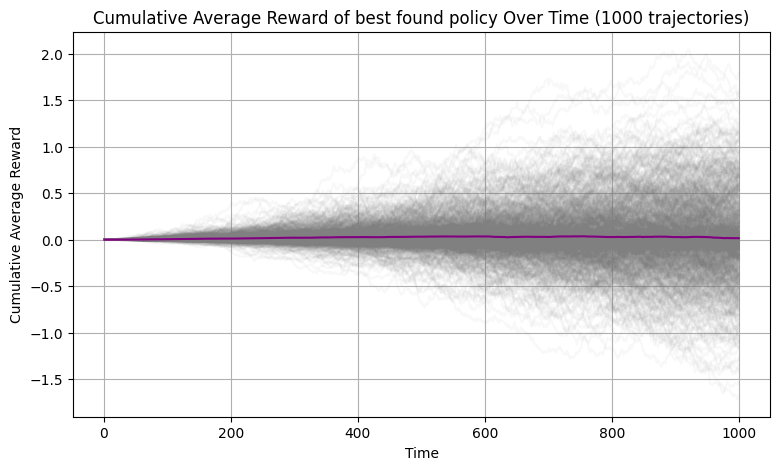

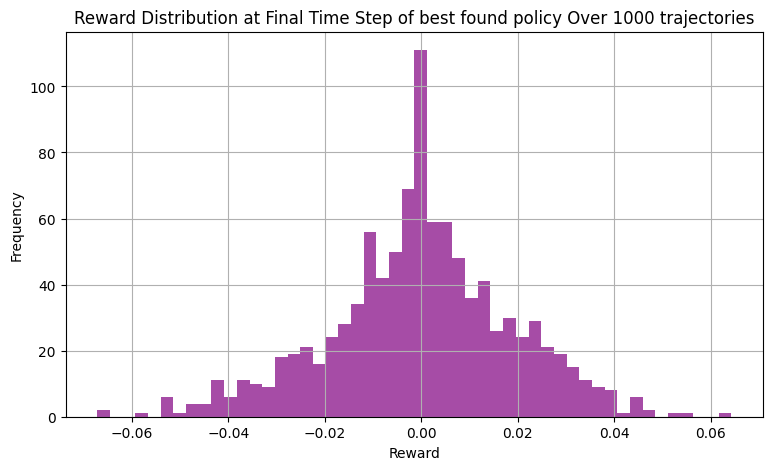

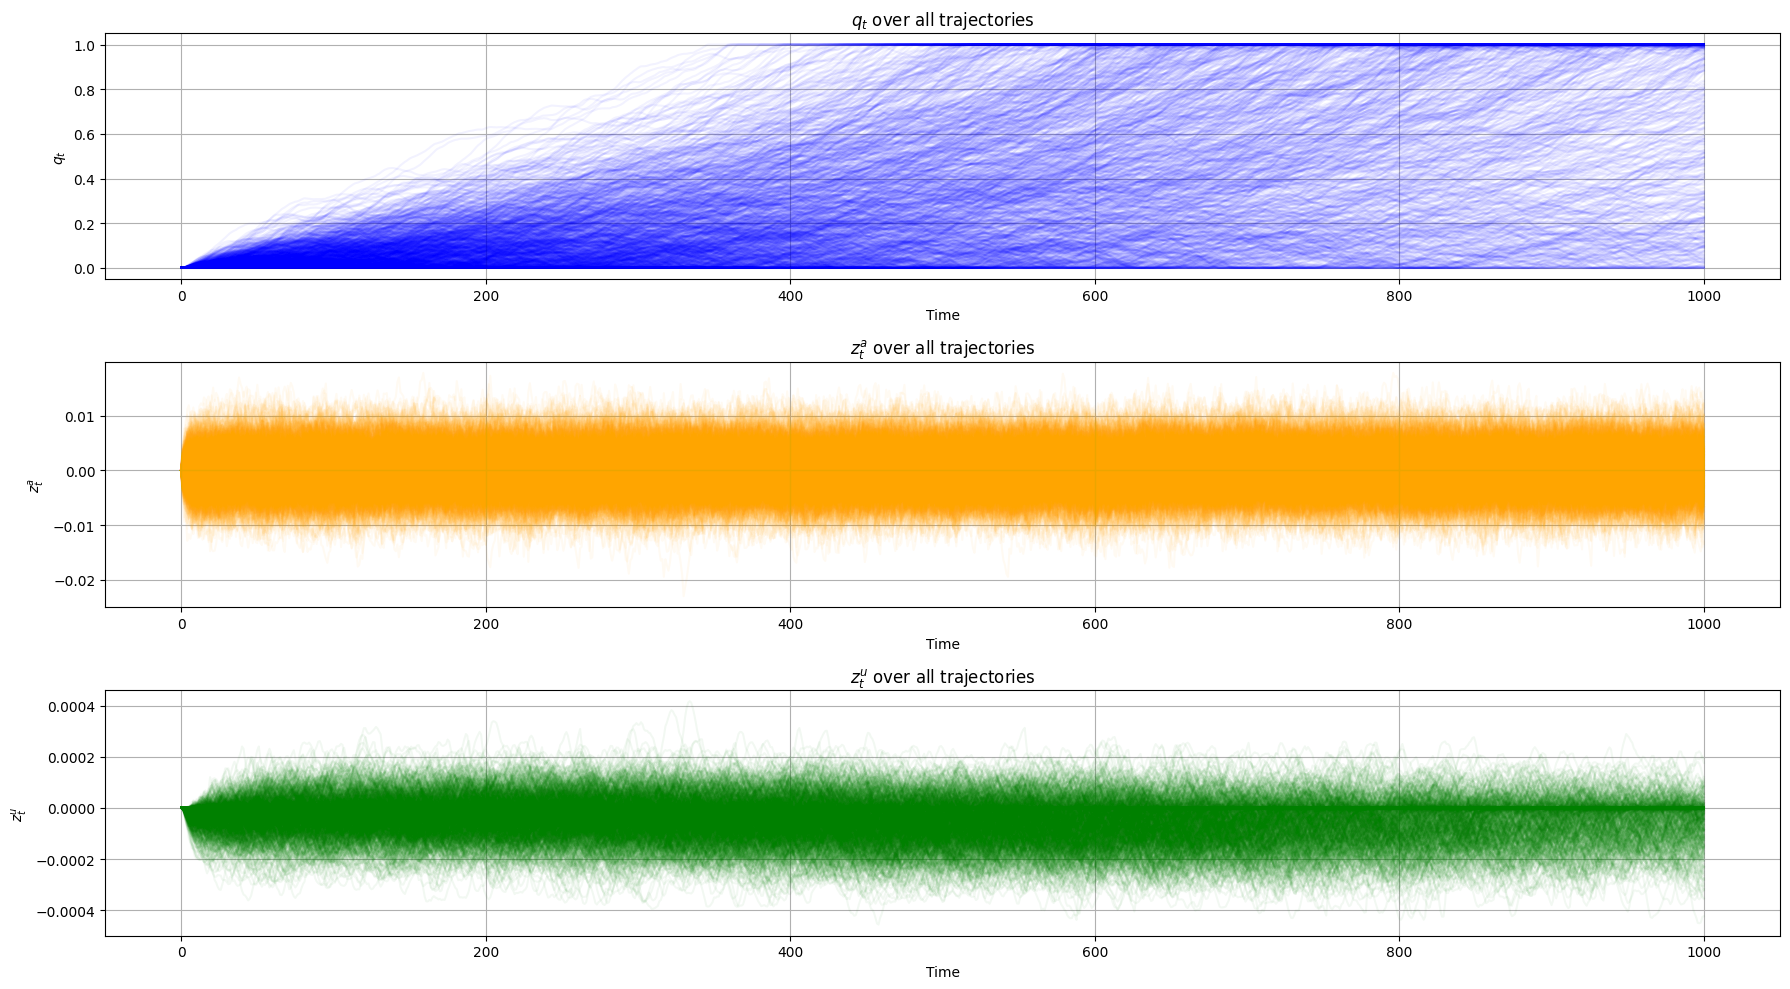

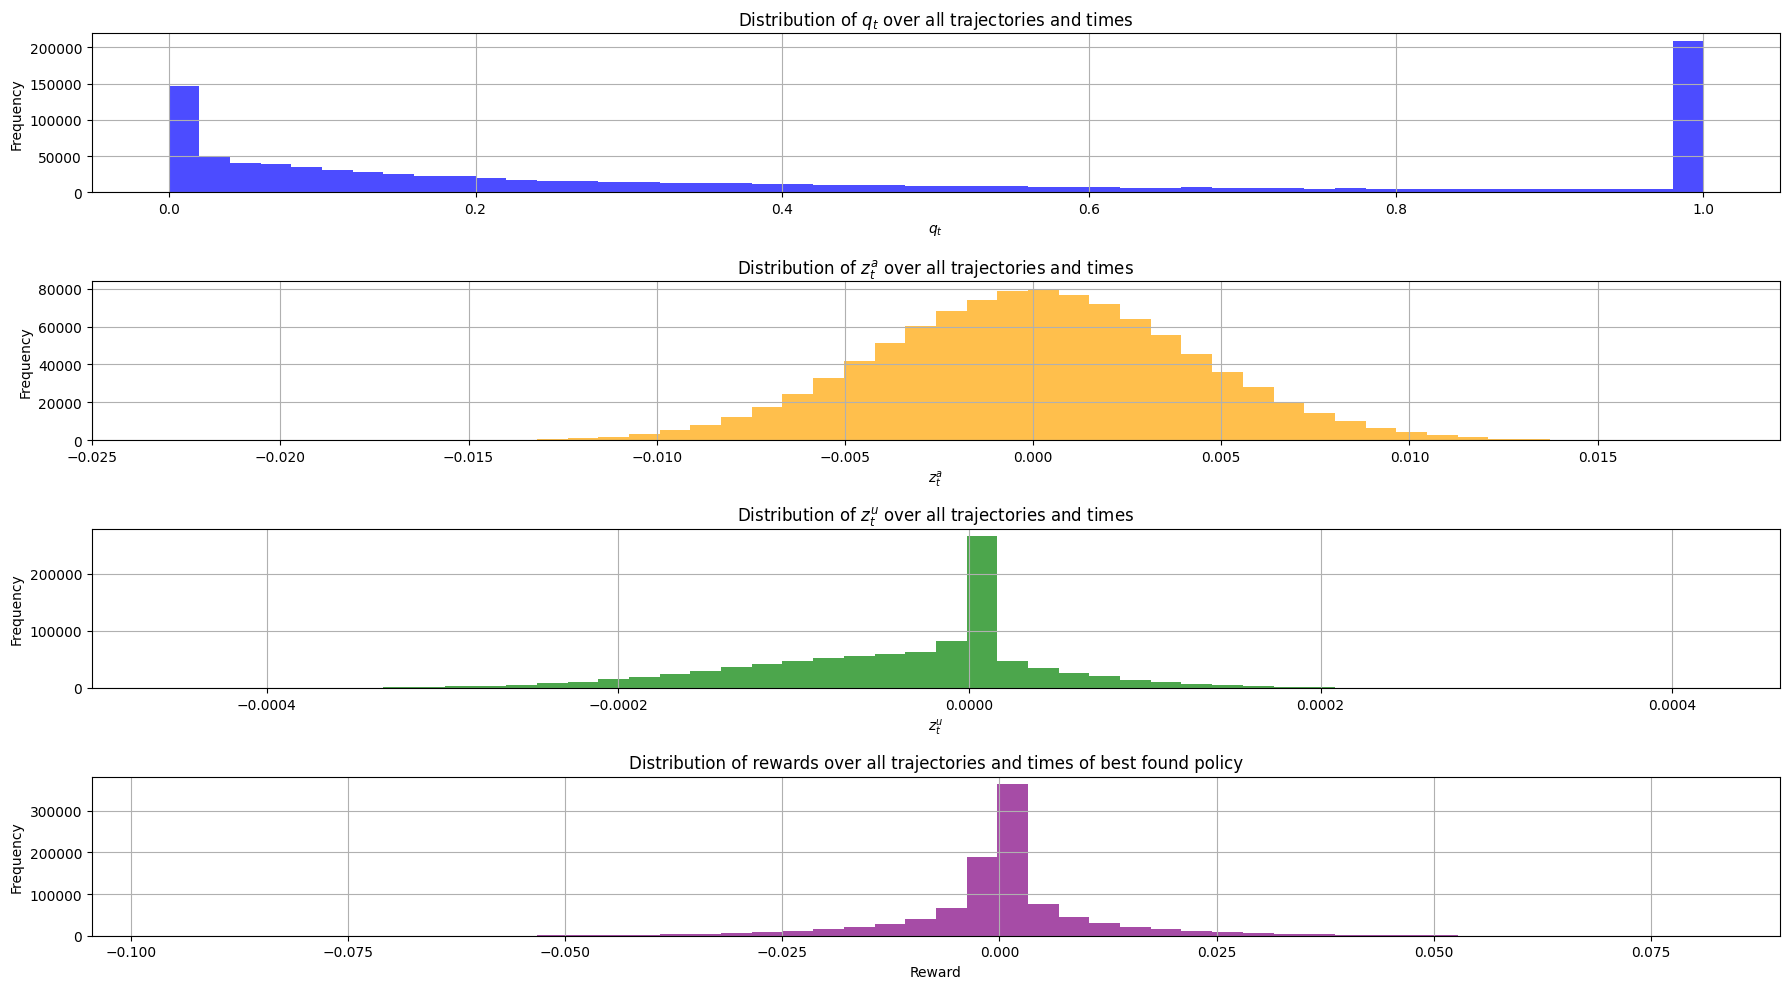

In [ ]:
# Finding the best policy by random search



range_params = 1.0
def random_policy():
    """Generate a random linear policy."""
    a = np.random.uniform(-range_params, range_params)
    b = np.random.uniform(-range_params, range_params)
    c = np.random.uniform(-range_params, range_params)
    params = (a, b, c)
    return lambda x: np.clip(a * x[0] + b * x[1] + c * x[2], -x[0], 1 - x[0]), params


def test_policy(policy, N=1000):
    reward_value = 0
    all_x, all_u, all_xi_p = generate_trajectories(policy, x0=(0, 0, 0), T=1000, N=N)
    all_rewards = reward(all_x[:, :, :], all_u[:, :], all_xi_p[:, :], 1000).T
    reward_value = np.mean(all_rewards)
    return reward_value

def linear_function(params): # linear function
    policy = lambda x: np.clip(params @ np.array([x[0], x[1], x[2]])
                               , -x[0], 1 - x[0])
    reward_value = test_policy(policy, N=1000)
    return reward_value


def quadratic_function(params): # 10 params
    # quadratic function
    x = np.array([0.5, 0.5, 0.5])  # example state to print the value of the policy
    # print(params @ np.array([x[0], x[1], x[2], x[0]**2, x[1]**2, x[2]**2, x[0]*x[1], x[0]*x[2], x[1]*x[2], 1]))
    policy = lambda x: np.clip(params @ np.array([x[0], x[1], x[2], x[0]**2, x[1]**2, x[2]**2, x[0]*x[1], x[0]*x[2], x[1]*x[2], np.ones_like(x[0])])
                               , -x[0], 1 - x[0])
    reward_value = test_policy(policy, N=1000)
    return reward_value


if best_params is None:
    # best_params = np.array(-0.00188275,  0.93751206, -0.24445238)
    # target_function = linear_function

    # [-0.00188275  0.93751206 -0.24445238]
    # Average reward of best found policy over 1000 trajectories: 0.00010859751707412008 and std: 0.0043908675038122884

    best_params = np.array([0]*10)  # 10 params for quadratic function
    target_function = quadratic_function


# ## just optimise the function using scipy
# from scipy.optimize import minimize
# print("Optimizing using scipy...")
# # res = minimize(lambda params: -target_function(params), x0=[0]*10, bounds=[(-range_params, range_params)]*10, method='L-BFGS-B')
# # that was not working well, stochastic function, use Nelder-Mead
# res = minimize(lambda params: -target_function(params), x0=[0]*10, bounds=[(-range_params, range_params)]*10, method='Nelder-Mead', options={'maxfev': 2000, 'disp': True})
# best_params = res.x
# print("Best params found by scipy:", best_params)
# print("Best reward found by scipy:", target_function(best_params))



best_reward = target_function(best_params)
print(f"best reward at start : {best_reward}")

alpha = 0.1
# optimise the function
for i in range(1000):
    new_params = best_params + np.random.normal(0, alpha, size=best_params.shape)
    new_reward = target_function(new_params)
    alpha *= 0.99  # decrease the step size over time
    if new_reward > best_reward:
        best_params = new_params
        best_reward = new_reward
        print(f"{i}  New best policy found with reward {best_reward} and parameters {best_params}")
    elif i % 50 == 0:
        best_reward = best_reward * 0.8 + target_function(best_params) * 0.2
    # if i % 10 == 0:
    #     print(f"{i}  Current best policy has reward {best_reward} and parameters {best_params}")

best_policy = lambda x: np.clip(best_params[0] * x[0] + best_params[1] * x[1] + best_params[2] * x[2], -x[0], 1 - x[0])

# x, u, xi_p = generate_trajectories(best_policy, x0=(0, 0, 0), T=1000)
# plot_trajectories(x, u, xi_p, filename=f"best_policy_{i}", mean=True, variance=True)
# plot_average_reward(x, u, xi_p, T=1000, filename="best_policy_final")

run_trajectories(best_policy, N=1000, name="best found policy", show_all=True)


In [ ]:
# here we show the evolution of the best reward found
import matplotlib.pyplot as plt
plt.plot(-res.convergence)
plt.title("Convergence of differential evolution")
plt.xlabel("Iteration")
plt.ylabel("Best reward found")
plt.show()

Average reward of best policy over 1000 trajectories: 0.00011033852853918974 and std: 0.003953600516018625


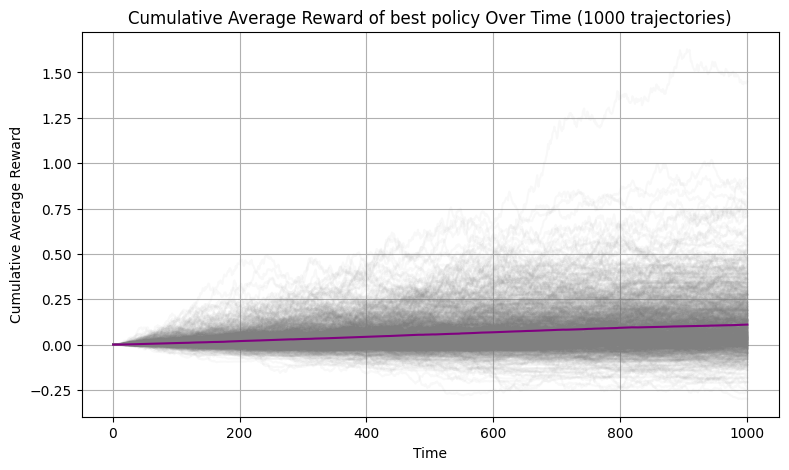

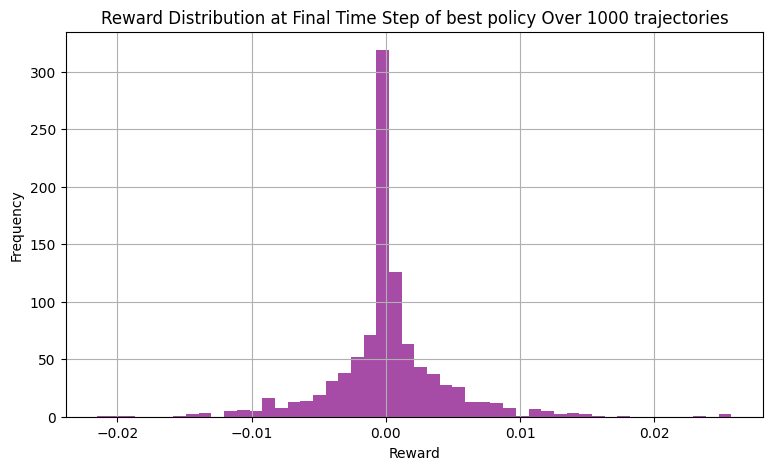

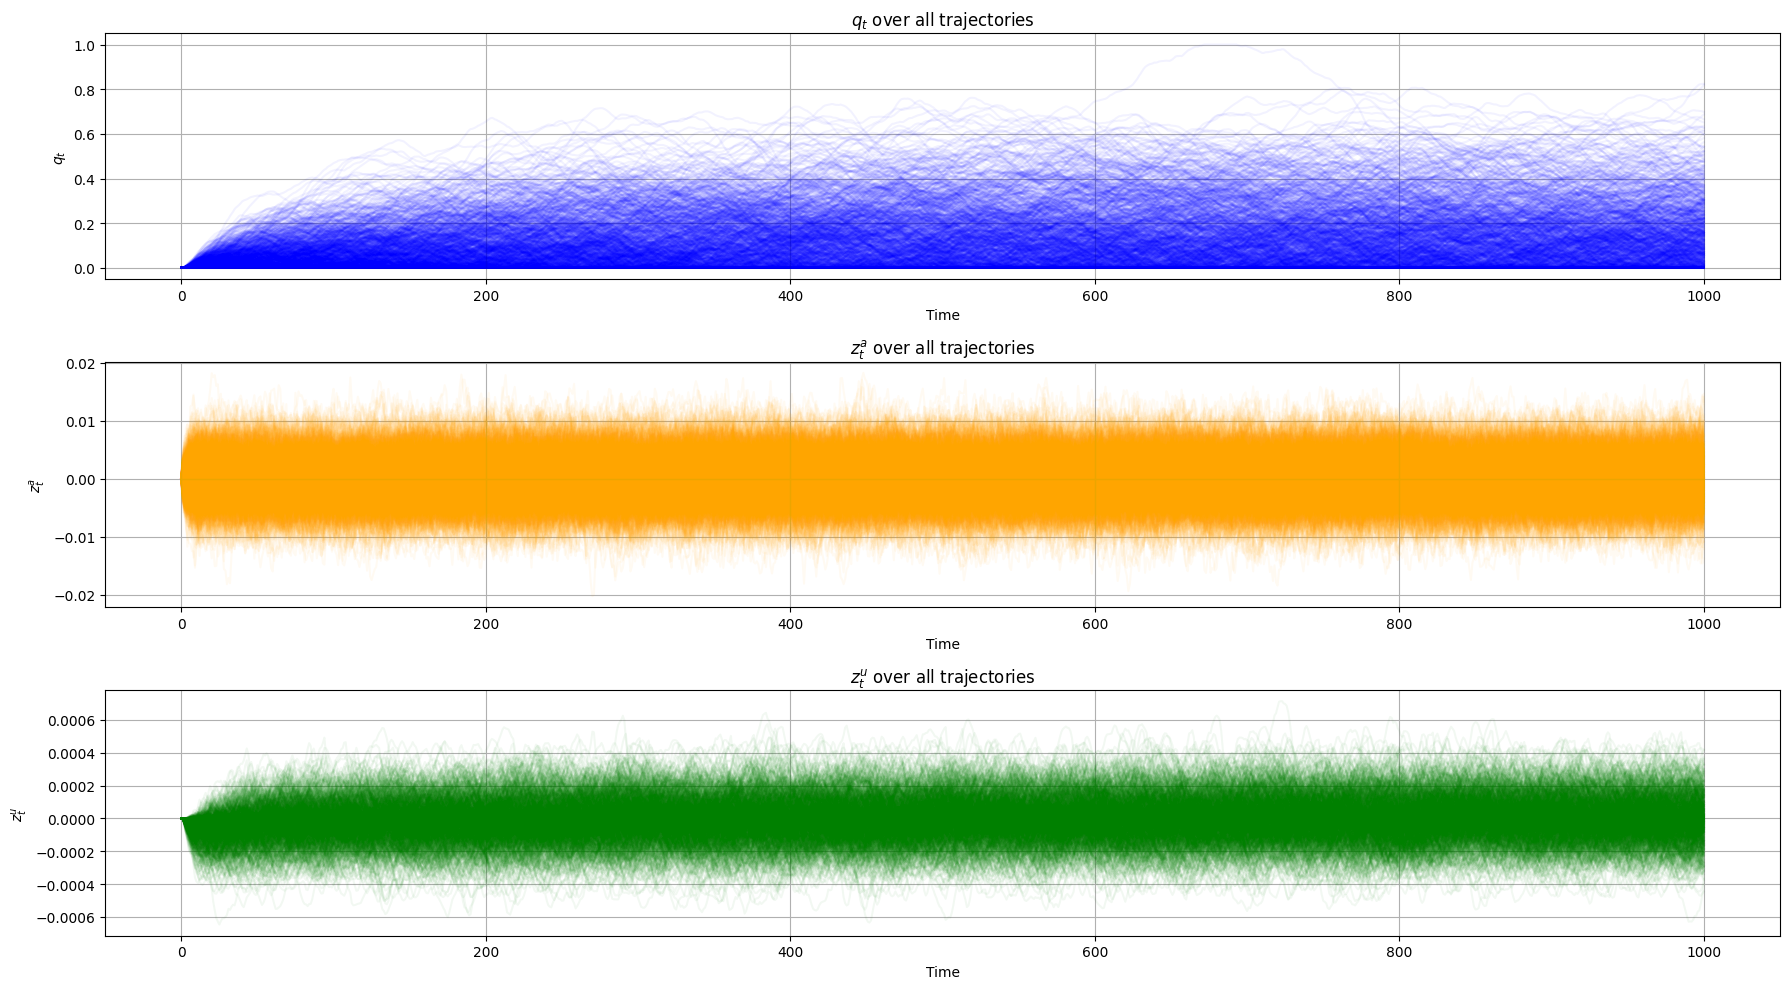

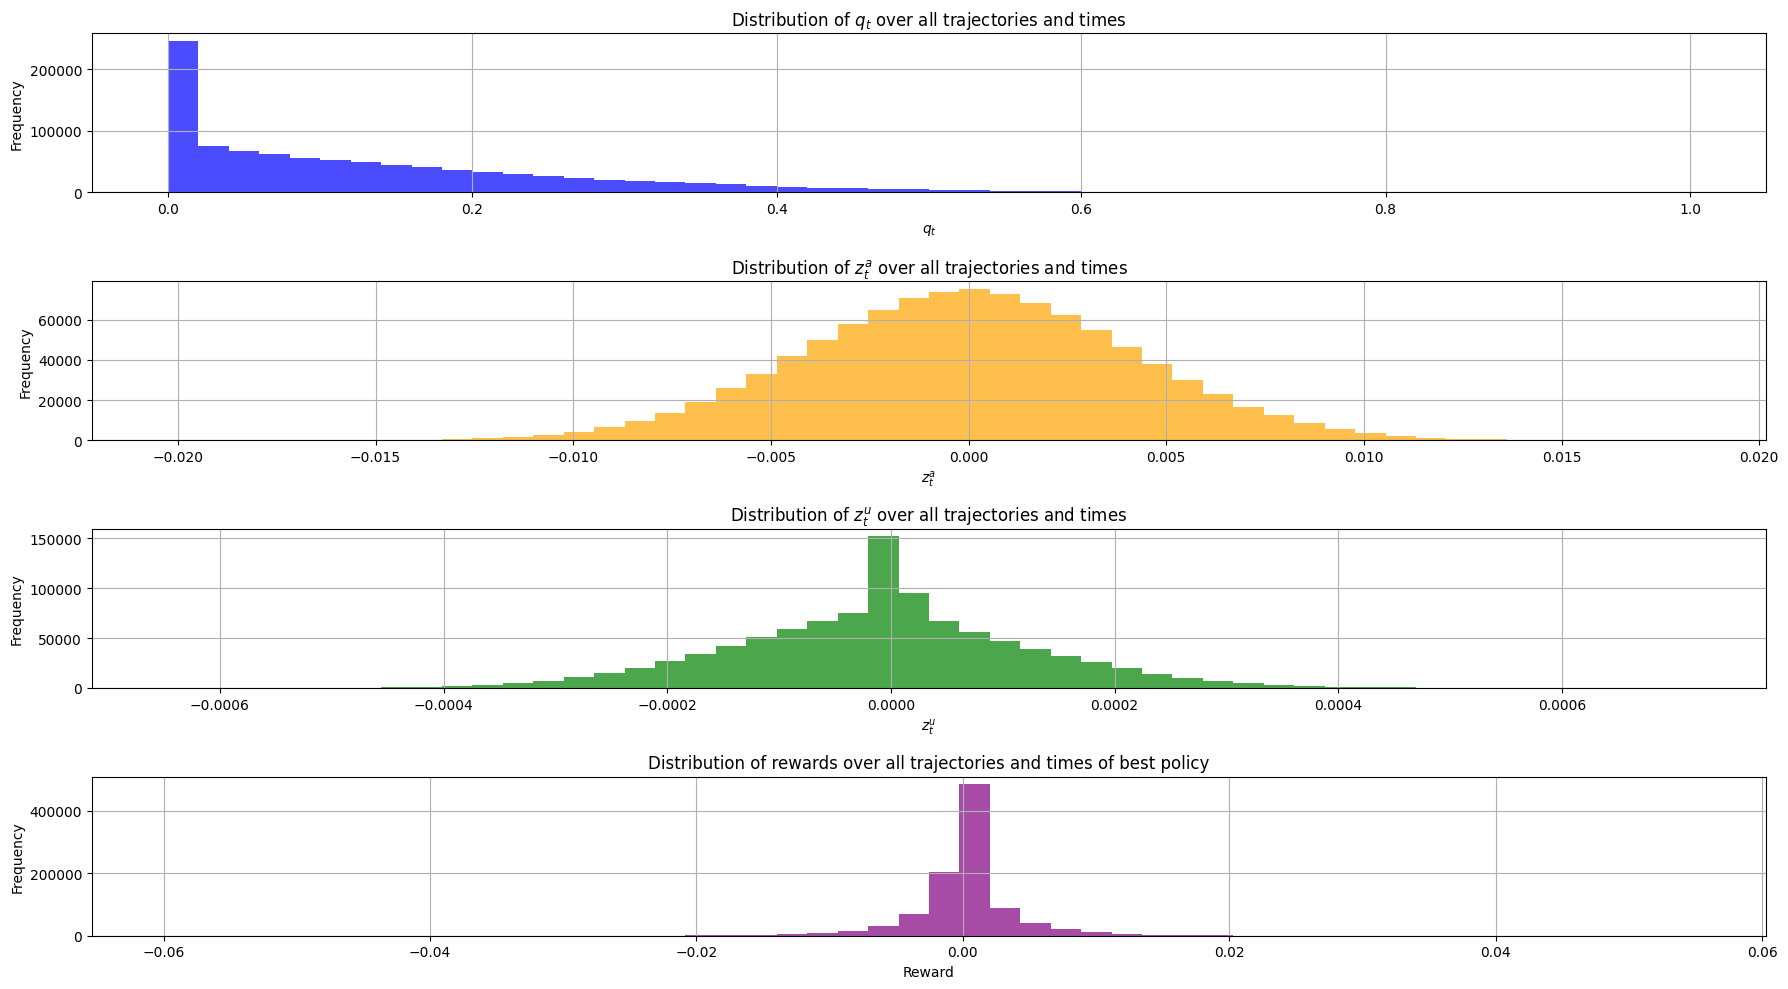

In [ ]:
best_policy = lambda x: np.clip(best_params[0] * x[0] + best_params[1] * x[1] + best_params[2] * x[2], -x[0], 1 - x[0])

run_trajectories(best_policy, N=N, name="best policy", show_all=True)



In [ ]:


# plot all the rewards
labels = ['Initial Policy', 'Clipped Initial Policy', 'Best Found Policy']
plt.figure(figsize=(10, 6))
plt.hist(all_rewards.T, bins=30, label=labels, alpha=1)
# add the mean of each distribution
for i in range(all_rewards.shape[0]):
    plt.axvline(np.mean(all_rewards[i]), color=f'C{i}', linestyle='dashed', linewidth=1)
plt.xlabel('Average Reward')

plt.title('Distribution of Average Rewards for Different Policies')
plt.ylabel('Average Reward')
plt.grid()
plt.legend()
plt.show()

# the integral plot
plt.figure(figsize=(10, 6))
for i in range(all_rewards.shape[0]):
    sorted_rewards = np.sort(all_rewards[i])
    cumulative = np.arange(1, len(sorted_rewards) + 1) / len(sorted_rewards)
    plt.plot(sorted_rewards, cumulative, label=labels[i])
    plt.axvline(np.mean(all_rewards[i]), color=f'C{i}', linestyle='dashed', linewidth=1)

plt.xlabel('Average Reward')
plt.title('Cumulative Distribution of Average Rewards for Different Policies')
plt.ylabel('Cumulative Density')
plt.grid()
plt.legend()
plt.show()

NameError: name 'all_rewards' is not defined

<Figure size 1000x600 with 0 Axes>